# Google drive setup
* Uses your google account's google drive to store dataset
* Make sure to create a folder "COMP-6721" in the root of your google drive before running this cell.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/COMP-6721")

Mounted at /content/drive


# Loading the dataset
* Downloads the face mask dataset to your drive and unzips it
* Loads the images and its labels to a pandas dataframe
* Save the dataframe as a  pickle file, so we don't need to run this cell again

In [ ]:
"""
Preparing the pickle
"""
from pathlib import Path

import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
from tqdm import tqdm
from pathlib import Path
import shutil


dirpath = Path('data/dataset')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
os.makedirs('data/dataset')
datasetPath = Path('data/dataset/dataset.zip')
gdd.download_file_from_google_drive(file_id='1tu9PmDx5mPCw1O-RTHLAzd25BGknsADQ',
                                    dest_path=str(datasetPath),
                                    unzip=True)
# delete zip file
datasetPath.unlink()

datasetPath = Path('data/dataset')
maskPath = datasetPath/'with_mask'
nonMaskPath = datasetPath/'without_mask'
randomPath = datasetPath/'random'
maskDF = pd.DataFrame()

for imgPath in tqdm(list(maskPath.iterdir()), desc='with_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='without_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

for imgPath in tqdm(list(randomPath.iterdir()), desc='random_images'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

dfName = 'data/dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

Unzipping...

with_mask:   1%|          | 32/3725 [00:00<00:11, 317.38it/s]

Done.


random_images: 100%|██████████| 3710/3710 [00:13<00:00, 282.92it/s]


Saving Dataframe to: data/dataset/dataset.pickle


# Custom dataset class
* Loads the dataset as PIL
* Resizes images to 32x32
* Convert image to tensor
* Normalizes images to have values in the range of 0-1

In [ ]:
"""
The DataSet class
"""
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Normalize


class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

# CNN model for face mask detection
* The model takes 3 channels(R,G,B) as input
* The model gives an output of one of 3 classes 
* 0 -> without_mask, 1 -> with_mask,2 -> not_a_person

In [ ]:
"""
The CNN model
"""
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential, functional)

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 3)
    
    def forward(self, x: Tensor):
        """ forward pass
        """
        out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

face_mask_detector_cnn = FaceMaskDetectorCNN()

# Layers in the model

In [ ]:
"""
Print model summary
"""

from torchsummary import summary
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2            [-1, 8, 16, 16]           1,160
            Linear-3                   [-1, 32]          16,416
            Linear-4                    [-1, 3]              99
Total params: 18,123
Trainable params: 18,123
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
----------------------------------------------------------------
None


# Split test, validation data
* Loads the pickle file that was saved previously
* Splits dataset into 70/30 split for test,validate
* Create a DataLoader helper function for automatic batching

In [ ]:
"""
Some utilities
"""
from pathlib import Path
from typing import Dict, List, Union

import pandas as pd
import torch
import torch.nn.init as init
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        # print the distribution
        print(mask_df['mask'].value_counts())
        train, validate = train_test_split(mask_df, test_size=0.3, random_state=0,
                                           stratify=mask_df['mask'])
        return [
            MaskDetectionDataset(train),
            MaskDetectionDataset(validate),
            CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=4)   

train_df, validate_df, cross_entropy_loss = prepare_data("data/dataset/dataset.pickle")

0.0    3828
1.0    3725
2.0    3710
Name: mask, dtype: int64


# Training the model
* For each batch get the images and its labels
* Pass it to the model to get predictions
* compare losses with actual, predicted values

In [ ]:
#@title Hyperparameters
epochs = 30 #@param {type:"slider", min:10, max:100, step:1}
learning_rate = 0.001 #@param {type:"number"}
retrain = False
"""
Training Step
"""
import warnings
warnings.filterwarnings('ignore')

def train_model():
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_df), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss
        print("Training Loss:", loss_train)

train_model()
print('Model training has finished')

Training Loss: tensor(152.9218, grad_fn=<AddBackward0>)
Training Loss: tensor(109.6861, grad_fn=<AddBackward0>)
Training Loss: tensor(92.6697, grad_fn=<AddBackward0>)
Training Loss: tensor(81.4858, grad_fn=<AddBackward0>)
Training Loss: tensor(73.8918, grad_fn=<AddBackward0>)
Training Loss: tensor(68.5356, grad_fn=<AddBackward0>)
Training Loss: tensor(60.8804, grad_fn=<AddBackward0>)
Training Loss: tensor(55.1276, grad_fn=<AddBackward0>)
Training Loss: tensor(50.2824, grad_fn=<AddBackward0>)
Training Loss: tensor(45.4863, grad_fn=<AddBackward0>)
Training Loss: tensor(40.7065, grad_fn=<AddBackward0>)
Training Loss: tensor(36.3088, grad_fn=<AddBackward0>)
Training Loss: tensor(31.1779, grad_fn=<AddBackward0>)
Training Loss: tensor(27.7230, grad_fn=<AddBackward0>)
Training Loss: tensor(24.4418, grad_fn=<AddBackward0>)
Training Loss: tensor(23.2069, grad_fn=<AddBackward0>)
Training Loss: tensor(19.3152, grad_fn=<AddBackward0>)
Training Loss: tensor(17.3041, grad_fn=<AddBackward0>)
Training

# Evaluate the model 
* Run the model to evaluate its accuracy on unseen images using validate dataset
* print model's accuracy, f1, precision, recall scores

In [ ]:
"""
Evaluate the model
"""

from numpy import vstack
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

def evaluate_model():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_df)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)

    # print metrics
    print(classification_report(actuals, predictions))
evaluate_model()

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      1148
         1.0       0.88      0.90      0.89      1118
         2.0       0.89      0.91      0.90      1113

    accuracy                           0.90      3379
   macro avg       0.90      0.90      0.90      3379
weighted avg       0.90      0.90      0.90      3379



# Predict the category of a random image

data/dataset/without_mask/without_mask_3545.jpg
Actual: without_mask
Predicted: without_mask


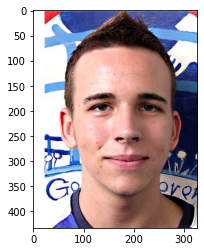

In [ ]:
"""
Predict
"""

import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "with_mask",
    2: "not_a_person"
}

def predict():
  rand_sampler = torch.utils.data.RandomSampler(validate_df, num_samples=32, replacement=True)
  data = iter(DataLoader(validate_df, batch_size=32, num_workers=1, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  print(data['path'][rand_ind])
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()